<a href="https://colab.research.google.com/github/kiyomi0917/DoSA-PJ/blob/main/%E5%B0%8F%E9%87%8E%E3%81%8D%E3%82%88%E7%BE%8E%EF%BC%BF%E6%88%90%E6%9E%9C%E7%89%A9_RandomForest__Random_Search_%E5%93%81%E8%A9%9E%E3%81%AE%E3%81%BF_0703.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install Janome==0.3.7
!pip install --upgrade scikit-learn

In [3]:
import sklearn
print(sklearn.__version__)


1.3.0


In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from janome.tokenizer import Tokenizer
import re


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

In [5]:
# Load the Excel file　読み込み
file_path = '/content/drive//MyDrive/DoSA/dataset_0619.xlsx'
xl = pd.ExcelFile(file_path)

# Load the desired sheet into a DataFrame　ファイルの指定シートを読み込み
df1 = xl.parse('訓練ﾃﾞｰﾀ')
df2 = xl.parse('ﾃｽﾄﾃﾞｰﾀ')

#ガイヨウトハラスメントハンテイヲ変数名に代入する（＝定義する）

train_data = df1["概要"]
train_labels =df1["ハラスメント判定"].astype(int)

test_data = df2["概要"]
test_labels = df2["ハラスメント判定"]

In [6]:
# テキストを分割する関数_テキストからすべての単語を抽出
t=Tokenizer()
def tokenize1(text):
    tokens = t.tokenize(text)
    word = []
    for token in tokens:
        word.append(token.surface)
    return word


# テキストから品詞(「名詞」「動詞」「形容詞」「形容動詞」)の単語を抽出し、全てひらがなまたは全て小文字英語の単語を除外
def tokenize2(text):
    tokens = t.tokenize(text)
    selected_words = []
    for token in tokens:
        # 「名詞」「動詞」「形容詞」「形容動詞」を取り出す
        if token.part_of_speech.split(',')[0] in ['名詞', '動詞', '形容詞', '形容動詞']:
            # 全てひらがなまたは全て小文字英語の単語は除外
            if not re.fullmatch("[あ-ん]*", token.surface) and not re.fullmatch("[a-z]*", token.surface):
                selected_words.append(token.surface)
    return selected_words


In [7]:
np.set_printoptions(threshold=np.inf)

In [8]:
#Tfid vecをvectorizerに代入する
vectorizer = TfidfVectorizer(tokenizer=tokenize2)#tokenizerは省略できない

#訓練データのトークン化・ベクトル化する
train_matrix = vectorizer.fit_transform(train_data)
train_matrix = train_matrix.toarray()#配列のかたをnumpy型にかえる
random.seed(42)

#元の配列を取ってランダムに並べ替える
rand_index = np.random.permutation(np.arange(len(train_matrix)))
print(rand_index)

#訓練データをランダムにシャッフルする処理
train_matrix = train_matrix[rand_index]
train_labels = train_labels[rand_index]

print(train_matrix)
print(train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


ストリーミング出力は最後の 5000 行に切り捨てられました。
  0.         0.         0.         0.         0.15462736 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.4781163
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
 

In [9]:
#訓練データから抽出された特徴量のリスト
feature_names = vectorizer.get_feature_names_out()
print(feature_names)


['1' '10' '16' '17' '2' '3' '4' '709' '①' '②' '③②' 'うつ病' 'お前' 'お子さん' 'お茶'
 'お願い' 'か月' 'その後' 'ぶん殴り' 'やる気' 'アイデア' 'アドバイス' 'アナウンス' 'アホ' 'エマ' 'エリア'
 'オッケー' 'カ月' 'クライアント' 'グラフィック' 'グループ' 'コミュニケーション' 'コンビニエンスストア' 'コール'
 'サービス' 'スイッチ' 'スキル' 'スタッフ' 'ストッキング' 'ストレス' 'ストーカー' 'ストーキング' 'スピード' 'センター'
 'セールス' 'タイミング' 'タクシー' 'タスク' 'チェック' 'チャンス' 'チンピラ' 'テスト' 'テーマ' 'デザイン' 'データ'
 'トーク' 'ノート' 'ハラスメント' 'ハードウェア' 'バカ' 'パソコン' 'パチンコ' 'パフォーマンス' 'パワハラ' 'パワー'
 'パート' 'ヒアリング' 'ピアス' 'フォロー' 'フォント' 'プロジェクト' 'ヘルメット' 'ボケ' 'マニュアル' 'マネージャー'
 'ミス' 'ミーティング' 'メッセージ' 'メモ' 'メンタル' 'メーカー' 'メール' 'ユニット' 'リサイクル' 'ルール' 'レベル'
 'レポート' 'ヶ月' '一' '一つ' '一切' '一定' '一対一' '一時' '一流' '一般' '一貫' '一連' '上' '上司'
 '上申' '上記' '上限' '下' '下がる' '下げ' '不利益' '不可能' '不合格' '不妊' '不安定' '不平' '不当'
 '不愉快' '不服' '不正' '不法' '不満' '不良' '不要' '不調' '不足' '不適切' '与え' '両手' '両親' '並べ'
 '中' '中傷' '中学校' '中旬' '中略' '中華' '中途' '主任' '主張' '主治医' '乗せ' '乗務' '乗車' '了解'
 '予定' '争う' '事' '事件' '事務' '事務所' '事実' '事情' '事故' '事案' '事業' '事由' '事象' '二の次'
 '交流' '交通' '交際' '人' '人事' '人前' '人格' '人権' '人気' '人目' '人間' '

In [10]:

#前のセルでトークン化した情報を表示
feature_names = vectorizer.get_feature_names_out()
for i in range(len(train_matrix)):
    tokens = [feature_names[j] for j in range(len(feature_names)) if train_matrix[i][j] > 0]
    print(f"トークン化結果 {i+1}: {tokens}")

#print(feature_names)
print(train_matrix.shape)

トークン化結果 1: ['10', '17', '2', '3', 'やる気', 'エリア', 'サービス', 'センター', 'メール', 'ユニット', '上司', '中途', '人', '仕事', '代理', '以上', '件', '会社', '何', '保険', '倍', '傷害', '入社', '処理', '十', '名', '含め', '員', '地位', '宛', '宛先', '審査', '専任', '席次', '年', '当該', '従業', '思い', '意欲', '所属', '挙げ', '損失', '搭乗', '数', '文字', '本日', '業務', '業績', '現在', '番目', '目', '給料', '総合', '者', '職', '記載', '課長', '赤', '辞める', '迷惑', '送信', '部下', '雇える']
トークン化結果 2: ['一時', '上司', '入社', '別室', '実施', '教育', '新人', '最近', '的', '短期間', '研修', '集中']
トークン化結果 3: ['チャンス', 'レベル', '上司', '与え', '人', '仕事', '会社', '低迷', '免職', '勧奨', '十分', '及び', '受け', '契約', '年', '後', '性', '懲戒', '成績', '旨', '明言', '求め', '無理', '用い', '症', '社員', '等', '筋', '繰り返し', '自主', '若年', '表現', '見極め', '言っ', '言動', '記憶', '認知', '辞め', '退職', '過ぎ', '長時間', '障害', '面談', '１']
トークン化結果 4: ['仕事', '別室', '労働', '外し', '意', '沿わ', '研修', '者', '自宅', '自身', '長期間', '隔離']
トークン化結果 5: ['クライアント', 'ストッキング', '上司', '会議', '参加', '女性', '履く', '指示', '素足', '部下']
トークン化結果 6: ['不妊', '了解', '人事', '伝達', '促す', '個人', '労働', '労務', '当該', '得', '必要', '性', '性的', '情報', 

In [11]:
#モデルを構築（モデルの定義）
model = RandomForestClassifier()

#RFにベクトル化した情報を入れて学習させる、モデル内で持っている数値=パラメーターを調整する
model.fit(train_matrix, train_labels)

#テストデータをトークン化/ベクトル化
test_matrix = vectorizer.transform(test_data)

#test_matrix`に対する予測結果が`test_predictions`として格納される`test_matrix`は入力データ（特徴量）の行列であり、`test_predictions`は予測結果（目的変数）を格納するための変数
#テストデータの予測
#このデータに0/1が入っている
test_predictions = model.predict(test_matrix)

#予測結果を数値化＆可視化する
#113のうち、どれだけ正しく該非判定ができたかということ
test_accuracy = accuracy_score(test_labels, test_predictions)
print("ﾃｽﾄﾃﾞｰﾀの正解率:", test_accuracy)

#モデルが正と予測したもの(本来は非該当の事例も含まれている）のうち、正が実際にいくつあったか
precision = precision_score(test_labels, test_predictions)
print("ﾃｽﾄﾃﾞｰﾀの適合率:", precision)

#実際にハラスメント（実際の件数）に該当する事例をどれだけ正しく判定できているか
recall = recall_score(test_labels, test_predictions)
print("ﾃｽﾄﾃﾞｰﾀの再現率:", recall)

f1 = f1_score(test_labels, test_predictions)
print("ﾃｽﾄﾃﾞｰﾀのF1score:", f1)

#テストデータの予測結果のテキスのデータ、予測結果、予測結果のラベル
result = {}
for text, pred, correct in zip(test_data, test_predictions, test_labels):
  if result.get(f"{correct}-{pred}", None)==None:
     result[f"{correct}-{pred}"] = [text]
  else:
     result[f"{correct}-{pred}"].append(text)

#key=1,0ヤ0,0などを表す
for key in result:
  print(key)
  for text in result[key]:
    print(text)
  print()

ﾃｽﾄﾃﾞｰﾀの正解率: 0.6428571428571429
ﾃｽﾄﾃﾞｰﾀの適合率: 0.625
ﾃｽﾄﾃﾞｰﾀの再現率: 0.7142857142857143
ﾃｽﾄﾃﾞｰﾀのF1score: 0.6666666666666666
0-0
工事現場で建設機械の使い方を間違えていた作業員に対してリーダーが大声で注意した。
前の会議が長引き、次の会議に参加するためにオフィスの廊下を走っていたら、同僚にぶつかって相手がころんでしまった。
採用された新入社員は、業務を行ううえで多くのミスがあったため、上司は面談し「ミスが非常に多い」「仕事が遅いのは問題ないから、ミスがないようチェックしてから提出ほしい」と何度も指導した。その後もこの社員はミスがが多く、上司は何度も個別面談を設定したが改善されなかった。
会議で上司が部下に指導をしてもその部下が黙ったままで返事をしないため、上司が厳しい口調で「返事をしなさい！」と注意した。

0-1
会社の業績が低迷してきたため、部下に簡易な仕事を与えた。
この部下は将来有望と感じたため、ストレッチする意味でこれまで部下が経験したことのない難易度の高い業務の遂行を任せた。
勤務中に大地震が発生し、天井の一部が崩れ落ちてきたため、その下敷きになりそうな同僚を思いっきり突き飛ばした。

1-1
消防士長は昨年４～１１月、訓練中に複数の後輩職員の頭や肩をたたいたほか、「朝まで寝ないで訓練しろ」と言うなどして精神的苦痛を与えた。
事務所内で上司が腰や胸などを度々触るので、また触られるかもしれないと思うと仕事が手に付かず就業意欲が低下している。
部下が上司に妊娠を報告したところ、「次回の契約更新はないと思え」と言われた。
同僚から「こんな忙しい時期に妊娠するなんて信じられない」と繰り返し言われ、精神的に落ち込み業務に支障が出ている。
高等学校教が女子教諭に対してなされた、授業・担任等の仕事外し、職員室内での隔離、別の部屋への隔離、自宅研修等の命令した。

1-0
男性社員が育児休暇を申請したところ、「育休は女がとるものだ」と言われた。
「バカ野郎」と相手を侮辱する



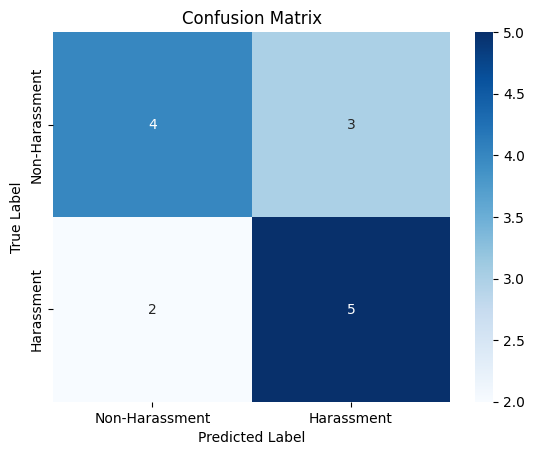

In [12]:
from sklearn.metrics import confusion_matrix

# 混同行列を作成
cm = confusion_matrix(test_labels, test_predictions)

# クラスのラベルを指定
class_labels = ['Non-Harassment', 'Harassment']

# 混合行列を可視化
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

# グラフの設定
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# グラフを表示
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from random import randint
import scipy

# データセットに合わせて train_X, train_y, test_X, test_y の値を定義する
train_X = train_matrix
train_y = train_labels
test_X = test_matrix
test_y = test_labels

# ハイパーパラメーターの値の候補を設定
model_param_set_random = {
    RandomForestClassifier(): {
        "n_estimators": scipy.stats.randint(1,300), # ランダムに1-299の範囲の整数を取り出す
        "max_depth": scipy.stats.randint(1,40),
        "min_samples_split": scipy.stats.randint(2,10), # 注意: min_samples_splitは最小でも2でないといけない        "random_state": [42]
    }
}

max_recall = 0
best_params_accuracy = None

#訓練データの一部をvalidationデータにする　書いていない場合は自動的に検証データは25%が適用される
train_X_temp, valid_X, train_y_temp, valid_y = train_test_split(train_X, train_y, random_state=42)

for model, param in model_param_set_random.items():

# Random Searchを使用してハイパーパラメーターの探索を行う。RandomizedSearchCVクラスを使用し、
# 指定したハイパーパラメーターの候補の中からランダムに組み合わせを選び、最適なパラメーターを探索します。
# その後、モデルの予測結果の正解率、適合率、再現率を計算し、最適なパラメーターと評価指標の値を更新します。

# Random Searchで最適なパラメーターを探索（recall）
    clf_recall = RandomizedSearchCV(model, param, scoring='recall')
    clf_recall.fit(train_X_temp, train_y_temp)
    pred_y = clf_recall.predict(valid_X)
    recall = recall_score(valid_y, pred_y)

    if recall > max_recall:
        max_recall = recall
        best_params_recall = clf_recall.best_params_

# 最適なパラメーターでモデルを再構築
best_model_recall = RandomForestClassifier(**best_params_recall)
best_model_recall.fit(train_X, train_y)

# テストデータを予測
pred_y = best_model_recall.predict(test_X)

# テストデータの正解率を計算して表示
accuracy = accuracy_score(test_y, pred_y)
print("テストデータの正解率:", accuracy)

# テストデータの適合率を計算して表示
precision = precision_score(test_y, pred_y)
print("テストデータの適合率:", precision)

# テストデータの再現率を計算して表示
recall = recall_score(test_y, pred_y)
print("テストデータの再現率:", recall)

# テストデータのF1スコアを計算して表示
f1 = f1_score(test_y, pred_y)
print("テストデータのF1スコア:", f1)

#テストデータの予測結果のテキスのデータ、予測結果、予測結果のラベル
result = {}
for text, pred, correct in zip(test_data, pred_y, test_labels):
  if result.get(f"{correct}-{pred}", None)==None:
     result[f"{correct}-{pred}"] = [text]
  else:
     result[f"{correct}-{pred}"].append(text)

#key=1,0ヤ0,0などを表す
for key in result:
  print(key)
  for text in result[key]:
    print(text)
  print()

テストデータの正解率: 0.7142857142857143
テストデータの適合率: 0.6666666666666666
テストデータの再現率: 0.8571428571428571
テストデータのF1スコア: 0.75
0-0
工事現場で建設機械の使い方を間違えていた作業員に対してリーダーが大声で注意した。
前の会議が長引き、次の会議に参加するためにオフィスの廊下を走っていたら、同僚にぶつかって相手がころんでしまった。
採用された新入社員は、業務を行ううえで多くのミスがあったため、上司は面談し「ミスが非常に多い」「仕事が遅いのは問題ないから、ミスがないようチェックしてから提出ほしい」と何度も指導した。その後もこの社員はミスがが多く、上司は何度も個別面談を設定したが改善されなかった。
会議で上司が部下に指導をしてもその部下が黙ったままで返事をしないため、上司が厳しい口調で「返事をしなさい！」と注意した。

0-1
会社の業績が低迷してきたため、部下に簡易な仕事を与えた。
この部下は将来有望と感じたため、ストレッチする意味でこれまで部下が経験したことのない難易度の高い業務の遂行を任せた。
勤務中に大地震が発生し、天井の一部が崩れ落ちてきたため、その下敷きになりそうな同僚を思いっきり突き飛ばした。

1-1
消防士長は昨年４～１１月、訓練中に複数の後輩職員の頭や肩をたたいたほか、「朝まで寝ないで訓練しろ」と言うなどして精神的苦痛を与えた。
事務所内で上司が腰や胸などを度々触るので、また触られるかもしれないと思うと仕事が手に付かず就業意欲が低下している。
部下が上司に妊娠を報告したところ、「次回の契約更新はないと思え」と言われた。
同僚から「こんな忙しい時期に妊娠するなんて信じられない」と繰り返し言われ、精神的に落ち込み業務に支障が出ている。
高等学校教が女子教諭に対してなされた、授業・担任等の仕事外し、職員室内での隔離、別の部屋への隔離、自宅研修等の命令した。
「バカ野郎」と相手を侮辱する

1-0
男性社員が育児休暇を申請したところ、「育休は女がとるものだ」と言われた。



In [14]:
# # 単語リストを取得
# feature_names = vectorizer.get_feature_names_out()

# for doc_no, vec in zip(range(len(train_data)), train_matrix):
#     print('doc_no:', doc_no)

#     sorted_words = sorted(enumerate(vec), key=lambda x: x[1], reverse=True)

#     for w_id, tfidf in sorted_words:
#         word = feature_names[w_id]
#         if tfidf != 0.0:
#             print('\t{0:s}: {1:f}'.format(word, tfidf))


In [15]:
# 単語リストを取得
feature_names = vectorizer.get_feature_names_out()

# TF-IDF値のリストを作成
tfidf_values = train_matrix[0]  # 例としてtrain_matrixの最初の文書のTF-IDF値を使用

# 単語と対応するTF-IDF値のペアを作成
word_tfidf_pairs = [(word, tfidf) for word, tfidf in zip(feature_names, tfidf_values)]

# TF-IDF値が高い順にソート
sorted_pairs = sorted(word_tfidf_pairs, key=lambda pair: pair[1], reverse=True)

# ソートされた単語とTF-IDF値を表示
for word, tfidf in sorted_pairs:
    if tfidf != 0.0:
        print('{0:s}: {1:f}'.format(word, tfidf))


職: 0.341429
数: 0.301071
ユニット: 0.218262
十: 0.218262
搭乗: 0.218262
件: 0.200714
名: 0.200714
思い: 0.188263
業務: 0.158428
部下: 0.118607
会社: 0.110716
10: 0.109131
エリア: 0.109131
中途: 0.109131
以上: 0.109131
保険: 0.109131
倍: 0.109131
傷害: 0.109131
含め: 0.109131
宛: 0.109131
審査: 0.109131
専任: 0.109131
席次: 0.109131
挙げ: 0.109131
文字: 0.109131
本日: 0.109131
現在: 0.109131
番目: 0.109131
給料: 0.109131
総合: 0.109131
赤: 0.109131
雇える: 0.109131
17: 0.100357
3: 0.100357
代理: 0.100357
宛先: 0.100357
所属: 0.100357
損失: 0.100357
目: 0.100357
辞める: 0.100357
やる気: 0.094132
サービス: 0.094132
意欲: 0.094132
業績: 0.094132
迷惑: 0.094132
送信: 0.094132
センター: 0.089303
メール: 0.089303
処理: 0.089303
地位: 0.089303
2: 0.085357
記載: 0.085357
入社: 0.082022
年: 0.082022
何: 0.079132
人: 0.076583
当該: 0.074303
課長: 0.070358
従業: 0.067022
員: 0.064132
仕事: 0.062820
者: 0.046584
上司: 0.036640


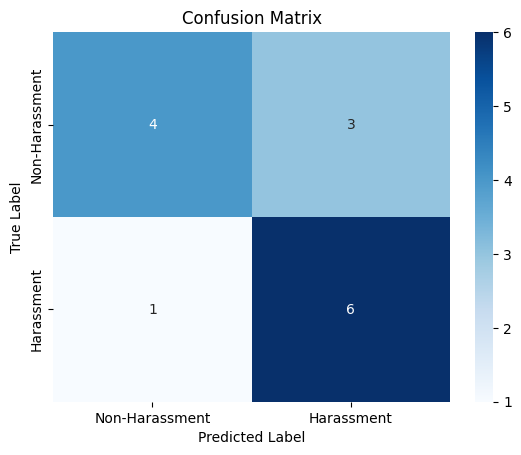

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# テストデータの混合行列を計算
cm = confusion_matrix(test_y, pred_y)

# クラスのラベルを指定
class_labels = ['Non-Harassment', 'Harassment']

# 混合行列を可視化
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

# グラフの設定
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# グラフを表示
plt.show()

In [17]:
import pickle

# 学習モデルを保存するパス
model_path = '/content/drive/MyDrive/model.pkl'

# 学習モデルを保存
with open(model_path, 'wb') as f:
    pickle.dump(best_model_recall, f)

# Saving model's performance
performance = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

# Saving performance metrics to the drive
performance_path = '/content/drive/MyDrive/performance.pkl'
with open(performance_path, 'wb') as f:
    pickle.dump(performance, f)

print("学習モデルを保存しました。")

学習モデルを保存しました。
